In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample, random, normalvariate, randint


def get_scores(num_photos):
    return [int(normalvariate(50,50)) for i in range(num_photos)]


def get_histogram(Y):
    fig = plt.figure(figsize=(8,6))
    plt.xlabel('Рейтинг фотографии')
    plt.ylabel('Количество')
    plt.hist(Y, bins=10, density=False)
    plt.grid(alpha=0.2)
    plt.show()

    
def collect_comparisons(true_scores, photo_ids, num_executors, num_comparisons_per_executor, error_probability):
    stats = {}
    for i in range(num_executors * num_comparisons_per_executor):
        p1,p2 = sample(photo_ids,2)

        p1,p2 = (p2,p1) if p2 < p1 else (p1,p2) # неупорядоченные пары

        stats.setdefault(p1,{}).setdefault(p2,{})
        stats[p1][p2].setdefault(True,0)
        stats[p1][p2].setdefault(False,0)

        true_result = true_scores[p1] > true_scores[p2]
        if random() < error_probability:
            true_result = not true_result

        stats[p1][p2][true_result] += 1 
    return stats


def build_graph(stats):
    graph = {}
    for p1 in stats:
        for p2 in stats[p1]:
            if stats[p1][p2][True] > stats[p1][p2][False]:
                graph.setdefault(p1,[])
                graph[p1].append(p2) # ребро есть если фото p1 лучше фото p2
            else:
                graph.setdefault(p2,[])
                graph[p2].append(p1) # ребро есть если фото p2 лучше фото p1
    return graph


def get_in_degree_all(graph):
    def no_input_edge(v):
        for p in graph:
            if v in graph[p]:
                return False
        return True
    d = {}
    for p in graph:
        for v in graph[p]:
            d.setdefault(v,0)
            d[v] += 1
        if no_input_edge(p):
            d[p] = 0
    return d


def get_best(graph):
    in_degree = get_in_degree_all(graph)
    ans = []
    for i in range(12):
        ans.append([p for p in in_degree if in_degree[p] == i])
    return ans
        


def remove_random_edge(graph, cycle):
    assert(len(cycle) > 2)
    a = graph[cycle[1]]
    del a[a.index(cycle[0])]


def dfs(p, graph, visited, topsorting):
    stack = [p]
    cycle = []
    cycle_detected = False
    while len(stack) > 0:
        p = stack[-1] # top
        if p not in visited: 
            if cycle_detected:
                stack.pop()
                continue
            else:
                visited[p] = 1 # make grey
        elif visited[p] == 1:
            visited[p] = 2 # make black
            stack.pop()
            topsorting.append(p)
            if cycle_detected:
                cycle.append(p)
            continue
        else:
            stack.pop()
            continue 
        if p in graph:
            for child in graph[p]:
                if child not in visited:
                    stack.append(child)
                elif visited[child] == 1: # grey vertex
                    cycle_detected = True
                    break
    return cycle
            
    
def check_cycles(graph):
    visited = dict()
    for p in graph.keys():
        cycle = dfs(p, graph, visited, [])
        if len(cycle) > 0:
            return cycle
    else:
        return []
    
    
def topsort(graph):
    visited = dict()
    ans = []
    for p in graph.keys():
        if p not in visited:
            dfs(p, graph, visited, ans)
    return ans[::-1]


In [3]:
def test_topsort():
    test_graph = {
        3:[8,10],
        5:[11],
        7:[11,8],
        8:[9],
        11:[2,9,10]
    }
    assert topsort(test_graph) == [7, 5, 11, 2, 3, 8, 9, 10]

In [4]:
def get_graph(stats): 
    graph = build_graph(stats)

    cycle_exists = True
    while cycle_exists:
        cycle = check_cycles(graph)
        if len(cycle) == 0:
            cycle_exists = False
        else:
            remove_random_edge(graph, cycle)

    return graph

In [53]:
def run_model(photo_scores):
    num_photos = 10
    num_executors = 3
    num_comparisons_per_executor = 10
    error_probability = 0.20

    photo_ids = list(range(len(photo_scores)))
    return collect_comparisons(photo_scores, photo_ids, num_executors, num_comparisons_per_executor, error_probability)

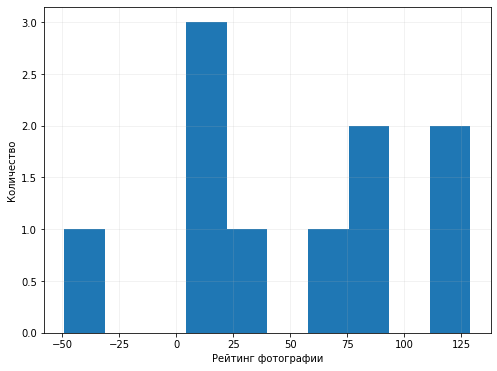

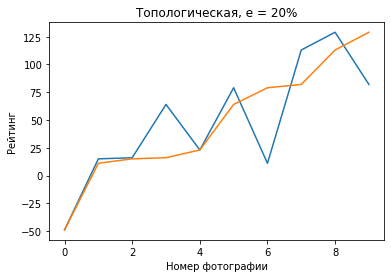

In [54]:
num_photos = 10
photo_scores = get_scores(num_photos)
get_histogram(photo_scores)

stats = run_model(photo_scores)

graph = get_graph(stats)

sorting = topsort(graph)[::-1]

plt.plot(list(range(len(sorting))),[photo_scores[p] for p in sorting])
plt.title('Топологическая, e = 20%')
plt.xlabel('Номер фотографии')
plt.ylabel('Рейтинг')

ideal = sorted(sorting, key = lambda x: photo_scores[x])
plt.plot(list(range(len(ideal))),[photo_scores[p] for p in ideal])





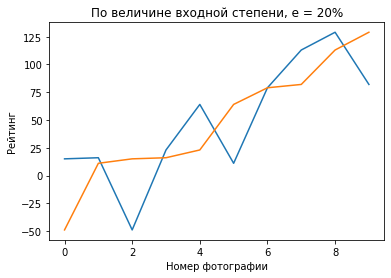

In [55]:
indegree = get_in_degree_all(graph)
ind_sorted = sorted(sorting, key = lambda x: -indegree[x])
plt.plot(list(range(len(ind_sorted))),[photo_scores[p] for p in ind_sorted])
plt.title('По величине входной степени, e = 20%')
plt.xlabel('Номер фотографии')
plt.ylabel('Рейтинг')

ideal = sorted(sorting, key = lambda x: photo_scores[x])
plt.plot(list(range(len(ideal))),[photo_scores[p] for p in ideal])

In [56]:
def measure():
    res = []
    for i in range(100):
        photo_scores = get_scores(num_photos)
        stats = run_model(photo_scores)
        graph = get_graph(stats)
        
        a = get_best(graph)
        a = [photo_scores[y] for x in a for y in x]
        res.append(a)
    return res

res = measure()

n = min(len(r) for r in res)
good_p = [0 for i in range(n)]
bad_p = [0 for i in range(n)]
for r in res:
    for i in range(n):
        good_p[i] += r[i] > 100
        bad_p[i] += r[i] < 50

s = len(res)
for i in range(n):
    good_p[i] /= s
    bad_p[i] /= s

print(good_p)
print(bad_p)

[0.46, 0.24, 0.17, 0.15, 0.11, 0.04, 0.09, 0.05, 0.05]
[0.11, 0.27, 0.39, 0.35, 0.44, 0.59, 0.53, 0.78, 0.77]


In [43]:
get_best(graph)

[[140, 133],
 [],
 [145, 128, 131],
 [148, 142],
 [126],
 [113, 63, 108],
 [45],
 [136, 43],
 [82],
 [119, 96, 104, 139],
 [30, 67, 87, 85, 70],
 []]